<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/data_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision


from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import shutil
import os
from google.colab import drive
import zipfile

In [5]:
def plot_avg_sale_prices_over_time(df, date_column='transaction_year_semi', price_column='transaction_price'):
    """
    Plots the average sale prices over time.

    Parameters:
    df (DataFrame): The dataset containing sales transactions.
    date_column (str): The column representing transaction year.
    price_column (str): The column representing sale price.
    """
    # Convert to DataFrame (if not already)
    df = pd.DataFrame(df)

    # Group by year and compute the average sale price
    avg_prices = df.groupby(date_column)[price_column].mean()

    # Plot the trend
    plt.figure(figsize=(12, 6))
    plt.plot(avg_prices.index, np.log(avg_prices.values), marker='o', linestyle='-', color='blue', label="Average Sale Price")
    plt.xlabel("Year of Sale")
    plt.ylabel("Average Transaction Price")
    plt.title("Average Transaction Prices Over Time")
    plt.grid(True)
    plt.legend()

    plt.show()

def plot_categorical_features(data, categorical_columns):


    # Visualize distribution of categorical variables
    fig, axes = plt.subplots(1, len(categorical_columns), figsize=(15, 5))

    for i, column in enumerate(categorical_columns):
        ax = axes[i]
        sns.countplot(x=column, data=data, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def repeated_to_single_transactions(df):
    """
    Transforms a dataset by splitting purchase and sale data into separate rows
    and renaming columns for consistency.
    """
    # Columns to keep (common info)
    common_columns = ['category', 'artist', 'height', 'width', 'medium']

    # Sale Data: Keep only relevant columns
    sale_data = df[common_columns + ['sale_year_semi', 'sale_price',
                                     'sale_house']].copy()
    sale_data = sale_data.rename(columns={
        'sale_year_semi': 'transaction_year_semi',
        'sale_price': 'transaction_price',
        'sale_house': 'transaction_house'
    })


    # Purchase Data: Keep only relevant columns
    purchase_data = df[common_columns + ['purchase_year_semi', 'purchase_price',
                                         'purchase_house']].copy()
    purchase_data = purchase_data.rename(columns={
        'purchase_year_semi': 'transaction_year_semi',
        'purchase_price': 'transaction_price',
        'purchase_house': 'transaction_house'
    })

    final_df = pd.concat([sale_data, purchase_data], ignore_index=True)

    return final_df


def one_hot(data, vars):
  # one-hot encoding for various categorical variables
  df = data.copy()
  return pd.get_dummies(df, columns=vars).astype(int)


def data_filter(data, vars, min_price=5000, min_house_occurence = 1000):
    df = data.copy()
    df.dropna(axis=0, how='any', inplace=True)
    df = df[(df['transaction_price'] >= min_price) & (df['transaction_price'] < np.exp(16))]

    house_counts = df['transaction_house'].value_counts()
    valid_houses = house_counts[house_counts >= min_house_occurence].index
    df = df[df['transaction_house'].isin(valid_houses)]

    return df[vars]

def data_split(data, vars, one_hot_vars, date_filter):

    df = data.copy()
    df = repeated_to_single_transactions(df)
    df = data_filter(df, vars)
    df = one_hot(df, one_hot_vars)
    df = add_prev_avg_price(df)

    train_data = df[(df['transaction_year_semi'] < date_filter)]
    test_data = df[(df['transaction_year_semi'] >= date_filter)]


    train_data = train_data.copy()
    test_data = test_data.copy()

    # Fit on train, transform both
    #scaler = MinMaxScaler()
    #train_data['transaction_year_semi'] = scaler.fit_transform(train_data[['transaction_year_semi']])
    #test_data['transaction_year_semi'] = scaler.transform(test_data[['transaction_year_semi']])


    # Prepare X and y for both training and testing
    X_train = train_data.drop(columns=['transaction_price', 'transaction_year_semi'])
    y_train = np.log(train_data['transaction_price'])

    X_test = test_data.drop(columns=['transaction_price', 'transaction_year_semi'])
    y_test = np.log(test_data['transaction_price'])

    # Ensure both X_train and X_test have the same columns (after dummy creation)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
    X_train, X_test = apply_pca_to_dummies(X_train, X_test)

    # Specify numerical features that need scaling
    numerical_features = ['height', 'width']

    # Apply standardization to numerical features
    X_train, X_test = standardization(X_train, X_test, numerical_features)

    return X_train, X_test, y_train, y_test


def standardization(train, test, numerical_features):

    scaler = StandardScaler()
    train[numerical_features] = scaler.fit_transform(train[numerical_features])
    test[numerical_features] = scaler.transform(test[numerical_features])
    return train, test



def add_prev_avg_price(data, date_column='transaction_year_semi', price_column='transaction_price'):
    """
    Computes the previous period's average price and adds it as a new feature.

    Parameters:
    df (pd.DataFrame): Input dataframe containing date and price columns.
    date_column (str): Name of the column representing the date in decimal year format.
    price_column (str): Name of the column representing the price.

    Returns:
    pd.DataFrame: DataFrame with an additional column 'prev_avg_price'.

    """

    df = data.copy()
    # Compute the average price per date
    avg_prices = df.groupby(date_column)[price_column].mean().reset_index()

    # Sort by date numerically
    avg_prices = avg_prices.sort_values(by=date_column)


    # Compute the rolling average for the last 4 periods
    avg_prices['prev_avg_price'] = avg_prices[price_column].rolling(window=4).mean().shift(1)
    avg_prices['prev_avg_price'] = np.log(avg_prices['prev_avg_price'])

    # Drop the first date since it has no previous average
    avg_prices = avg_prices.dropna()

    # Merge back with the original dataset
    df = df.merge(avg_prices[[date_column, 'prev_avg_price']], on=date_column, how='left')

    # Drop rows where 'prev_avg_price' is NaN (these belong to the first date)
    df = df.dropna(subset=['prev_avg_price'])

    return df



def apply_pca_to_dummies(X_train, X_test, n_components=100):
    # Select the dummy variable columns (transaction house and categories)
    dummies_columns = [col for col in X_train.columns if col.startswith('transaction_house_') or col.startswith('artist_')]

    # Extract the dummy variable columns
    X_train_dummies = X_train[dummies_columns]
    X_test_dummies = X_test[dummies_columns]

    # Apply PCA to the dummy variables (fit and transform on training data, transform on test data)
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_dummies)
    X_test_pca = pca.transform(X_test_dummies)

    # Convert the PCA results back to DataFrames with appropriate column names
    X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PCA_{i+1}' for i in range(n_components)], index=X_train.index)
    X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PCA_{i+1}' for i in range(n_components)], index=X_test.index)

    # Drop the original dummy columns and merge the PCA features
    X_train = X_train.drop(columns=dummies_columns).join(X_train_pca_df)
    X_test = X_test.drop(columns=dummies_columns).join(X_test_pca_df)

    return X_train, X_test

def fit_visualization(X, y):
    target = np.array(X, dtype=np.float64)
    prediction_numerical_model = np.array(y, dtype=np.float64)

    # Compute R-squared using sklearn
    r_squared = r2_score(target, prediction_numerical_model)
    print(f"R-squared: {r_squared:.3f}")

    # Compute regression line parameters using linregress
    slope, intercept, r_value, p_value, std_err = linregress(target, prediction_numerical_model)

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(target, prediction_numerical_model, alpha=0.5, label='Predictions')

    # Plot the regression line
    plt.plot(target, slope * target + intercept, color='black', label=f'Regression Line (R²={r_squared:.3f})')

    # Plot y=x line (perfect predictions)
    plt.plot([min(target), max(target)], [min(target), max(target)], color='green', linestyle='--', label='Perfect Prediction')

    # Labels and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Transaction Prices')
    plt.legend()

    # Annotate the regression equation on the plot
    equation_text = f"y = {slope:.3f}x + {intercept:.3f}"
    plt.text(min(target), max(prediction_numerical_model) * 0.9, equation_text, fontsize=12, color='black')

    # Show the plot
    plt.show()

def load_image_data(zip_path, image_path):

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    file_list = [f for f in file_list if not f.startswith('__MACOSX')]
    zip_ref.extractall(extract_path, members=file_list)
  print(f"Dateien entpackt in: {extract_path}")

# Function to check if an image file exists
def check_image_existence(image_paths, base_dir):
    missing_images = []  # To store paths of missing images
    nans = 0
    invalid_url = 0
    for image_path in image_paths:
        # Skip if the path is not a valid string (e.g., NaN or None)
        if isinstance(image_path, str) and image_path.strip():  # Check if it's a valid non-empty string
            # Construct the full image path based on the base directory
            full_image_path = os.path.join(base_dir, image_path.lstrip('/'))  # Remove leading slash, if any

            # Check if the file exists
            if not os.path.exists(full_image_path):
                missing_images.append(full_image_path)  # Add to missing list if not found
                invalid_url += 1
        else:
            nans += 1
    print(f"number of nans: {nans}")
    print(f"missing images: {invalid_url}")
    return missing_images

def filter_data_for_missing_images(data, missing_images, base_dir):
    # Extract only relative paths from missing_images
    data = data.dropna(subset=['image_url'])
    missing_relative_paths = [os.path.relpath(img, base_dir) for img in missing_images]
    data_filtered = data[~data['image_url'].str.lstrip('/').isin(missing_relative_paths)]

    return data_filtered

def resnet_transform():
  return  torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),            # Resize the image to be at least 256px
    torchvision.transforms.CenterCrop(224),        # Crop the center 224x224
    torchvision.transforms.ToTensor(),             # Convert the image to a tensor
    torchvision.transforms.Normalize(              # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],    # ImageNet mean values
        std=[0.229, 0.224, 0.225]      # ImageNet std values
    )])

Mounted at /content/drive


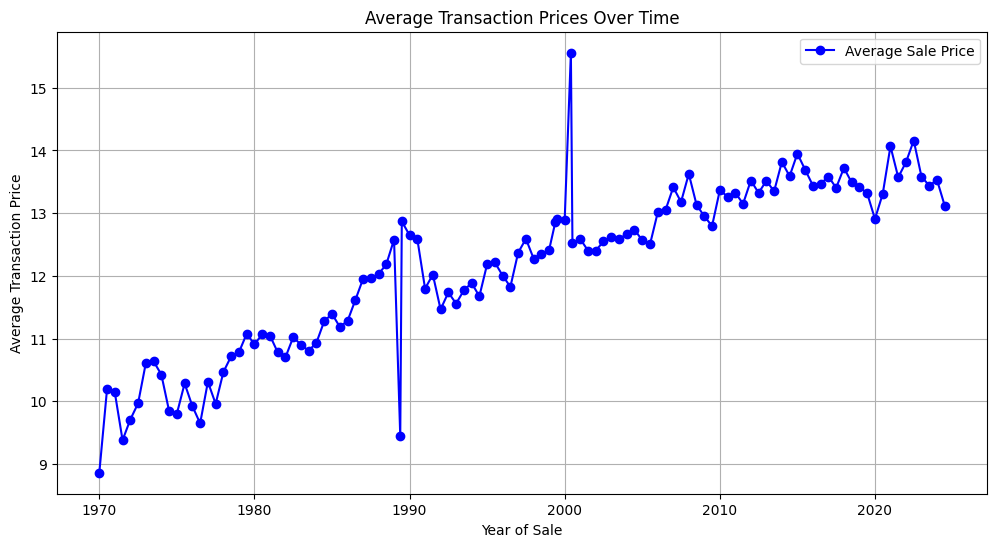

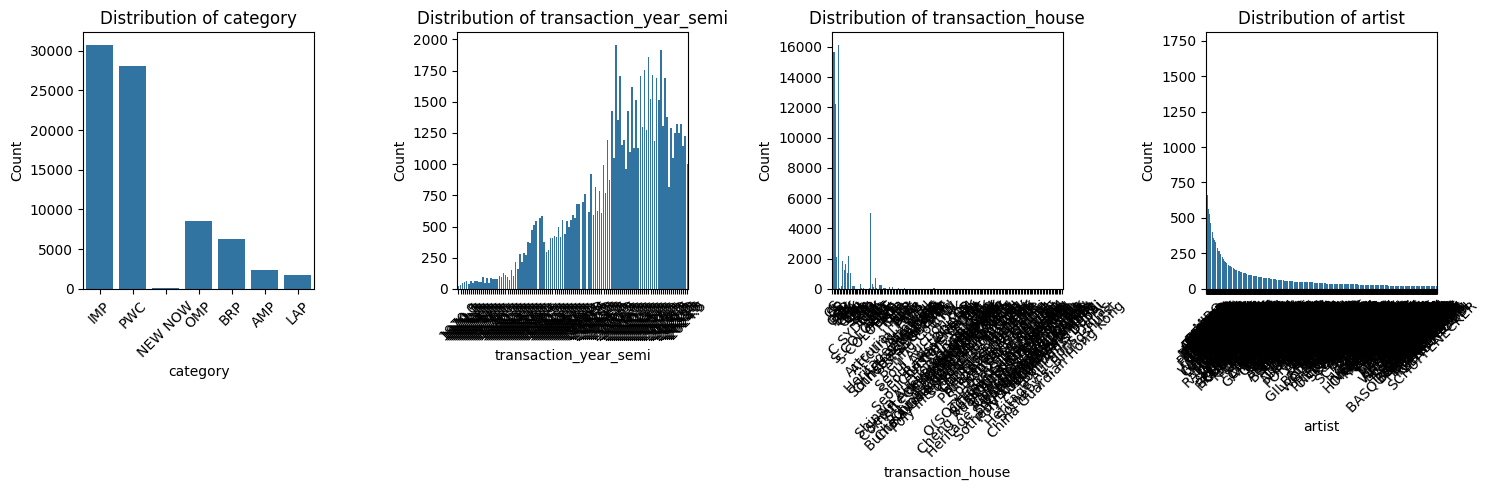

Dateien entpackt in: /content/data
number of nans: 1201
missing images: 86
number of nans: 0
missing images: 0
After filtering:[] 


In [3]:
if __name__ == "__main__":


  drive.mount('/content/drive')
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  # Define source and destination paths
  source_path = "/content/drive/My Drive/Colab Notebooks/data_preprocess.ipynb"
  destination_path = "/content/drive/My Drive/data_preprocess.ipynb"

  # Check if the source file exists before moving
  if os.path.exists(source_path):
    # Move the file
    shutil.move(source_path, destination_path)
    print(f"Notebook moved to: {destination_path}")

  # visualizations
  visualization_data = repeated_to_single_transactions(artwork_numeric_data)
  plot_avg_sale_prices_over_time(visualization_data)
  categorical_columns = ['category', 'transaction_year_semi', 'transaction_house', 'artist']
  plot_categorical_features(visualization_data, categorical_columns)

  # image daa
  zip_path = "/content/drive/My Drive/pic.zip"
  extract_path = "/content/data"
  load_image_data(zip_path, extract_path)
  # Check for missing images
  base_dir = "/content/data"
  image_paths = artwork_numeric_data['image_url'].values
  missing_images = check_image_existence(image_paths, base_dir)
  data_filtered = filter_data_for_missing_images(artwork_numeric_data, missing_images, base_dir)
  # check functioning of image data after filtering
  print(f"After filtering:{check_image_existence(data_filtered['image_url'],base_dir)} ")








